Migratoin to TensorFlow/Keras. Incomplete as the performance is not reached to the paper yet. 

In [ ]:
import tensorflow as tf
import keras
import random
import glob
from PIL import Image
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def random_crop(dir_img: str, crop_size: int):
    """function will create sampled image of specified dimensions from input image
    inputs:
           - img(str) : main image to take samples from
           - crop_size(int) : specified cropping dimensions
    outputs:
           - coords (tuple[x,y])) : x,y coordinates for top-left corner of random crop
           - crop_img (np.ndarray) : randomly sampled image
    """
    img = Image.open(dir_img)
    if img.mode == "RGBA":
        img = img.convert("RGB")
    img = np.array(img)
    img = img.astype(np.uint8)

    width, height = img.shape[:2]

    # coordinate for random crop, top-left corner
    x = random.randrange(0, width - crop_size, 1)
    y = random.randrange(0, height - crop_size, 1)

    return img[x : x + crop_size, y : y + crop_size], (x, y)


def get_data(dir_dataset: str, dataset_size: int, crop_size: int, augment=True) -> np.ndarray:
    """function will perform random cropping for multiple samples from one image
    inputs:
           - dataset_dir (str) : path to users image directory
           - dataset_size (int) : size of dataaset to prepare
           - crop_size(int) : dimension of cropped image
    outputs:
           - dataset(np.ndarray) : randomly db sampled cases, [number of cases, width, height, 3]
    """
    dir_cases1 = glob.glob(osp.join(dir_dataset, "*jpg"))
    dir_cases2 = glob.glob(osp.join(dir_dataset, "*png"))
    dir_cases = dir_cases1 + dir_cases2

    num_cases = len(dir_cases)
    if augment:
      dataset = np.zeros((dataset_size * 4, crop_size, crop_size, 3), dtype=np.uint8)
    else: 
      dataset = np.zeros((dataset_size, crop_size, crop_size, 3), dtype=np.uint8)
      
    samples_per_case = dataset_size // num_cases
    remaining = dataset_size % num_cases

    db_idx = 0
    # equally sample from cases in directory
    for case in dir_cases:
        for sample_idx in range(samples_per_case):
            sampled_case, _ = random_crop(case, crop_size)
            dataset[db_idx] = np.copy(sampled_case)

            if augment: 
              dataset[db_idx+1] = np.copy( np.rot90(sampled_case, 1) )
              dataset[db_idx+2] = np.copy( np.rot90(sampled_case, 2) )
              dataset[db_idx+3] = np.copy( np.rot90(sampled_case, 3) )
              db_idx += 4
            else: 
              db_idx += 1

    # sample remainders
    for idx in range(remaining):
        sampled_case, _ = random_crop(dir_cases[idx], crop_size)
        dataset[db_idx] = np.copy(sampled_case)
        db_idx += 1

    dataset = ( (dataset / 255.) * 2.0 ) - 1.0
    return dataset

dir_data = '/Users/lukeweger/Documents/desktop/research/images'
dataset = get_data(dir_data, 10, 192, True )
dataset.shape

(40, 192, 192, 3)

In [3]:
# sample noise
def sample_noise(batch_size=3, zx = 2, zg = 15, zl = 30 ):
  zn = zg + zl 
  z = np.zeros( (batch_size, zx, zx, zn) )
  z[:, :, :, zg:zn] = np.random.uniform( -1., 1., (batch_size, zx, zx, zl) )
  z[:, :, :, :zg] = np.random.uniform( -1., 1., (batch_size, 1, 1, zg) ) 
  return z
  

zs = sample_noise(5)
zs.shape

(5, 2, 2, 45)

In [4]:
# Scientific Report GAN architecture
def make_generator(in_shape=None):
  model = tf.keras.Sequential()
  fs = [512, 256, 128, 64,3]
  if in_shape is None: 
    model.add( keras.layers.InputLayer( input_shape=(None, None, 45) ) )
  else: 
    model.add( keras.layers.InputLayer( input_shape=(in_shape, in_shape, 45) ) )

  for i in range(4):
    model.add( keras.layers.Conv2DTranspose( fs[i], (5,5), strides=(2,2), padding='same') )
    model.add( keras.layers.ReLU() )
    model.add( keras.layers.BatchNormalization() )
  
  model.add( keras.layers.Conv2DTranspose( fs[-1], (5,5), strides=(2,2), padding='same', activation='tanh' ) )
  return model

def make_discriminator(in_shape=None): 
  model = tf.keras.Sequential()
  fs = [64, 128,  512, 1]
  if in_shape is None: 
    model.add( keras.layers.InputLayer( input_shape=(None, None, 3) ) )
  else: 
    model.add( keras.layers.InputLayer( input_shape=(in_shape, in_shape, 3) ) )

  for i in range(3):
    model.add( keras.layers.Conv2D( fs[i], (5,5), strides=(2,2), padding='same' ) )
    model.add( keras.layers.LeakyReLU(0.2) )
    model.add( keras.layers.BatchNormalization() )
  
  model.add( keras.layers.Conv2D( fs[-1], (5,5), strides=(4,4), padding='same', activation='sigmoid') )
  return model

In [5]:
# create models 
gen = make_generator(2)
gen.summary()

disc = make_discriminator(64)
disc.summary()

2022-12-14 13:45:50.284892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        576512    
 nspose)                                                         
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        3277056   
 ranspose)                                                       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 256)         0         
                                                        

In [6]:
zs=sample_noise(batch_size=6, zx=2)
gen_out=gen.predict(zs)
print(gen_out.shape)

1/1 [==============================] - 0s 477ms/step
(6, 64, 64, 3)


In [7]:
# loss functions 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse = tf.keras.losses.MeanSquaredError()

def loss_disc(real_output, fake_output):
  real_loss = cross_entropy( tf.ones_like(real_output), real_output )
  fake_loss = cross_entropy( tf.zeros_like(fake_output), fake_output )
  total_loss = real_loss + fake_loss
  return total_loss

def loss_gen(fake_output):
  return cross_entropy( tf.ones_like( fake_output), fake_output )

# optimizers
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dis_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [8]:
#EPOCHS = 1
#noise_dim = 45
BATCH_SIZE = 3
epoch_iters = BATCH_SIZE * 500

@tf.function
def train_step(images, g):
  noise = sample_noise( BATCH_SIZE )
  if g:
    with tf.GradientTape() as gen_tape:
      gen_imgs = gen(noise, training=True)
      fake_output = disc(gen_imgs, training=True)
      gen_loss = loss_gen(fake_output)
    grads_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gen_opt.apply_gradients( zip(grads_gen, gen.trainable_variables) )
    return float(gen_loss)
  else: 
    with tf.GradientTape() as disc_tape:
      gen_imgs = gen(noise, training=True)
      real_output = disc(images, training=True)
      fake_output = disc(gen_imgs, training=True)
      disc_loss = loss_disc(real_output, fake_output)
    grads_dis = disc_tape.gradient(disc_loss, disc.trainable_variables)
    dis_opt.apply_gradients( zip(grads_dis, disc.trainable_variables) ) 
    return float(disc_loss)


In [9]:
dir_data = '/path/to/data/directory' # should be updated to your data set
disc_losses=[]
def train(epochs, verbose=0):
  dataset = get_data(dir_data, dataset_size=1000, crop_size=64)
  for epoch in range(epochs):
    print( 'epoch', epoch, ':', end='\t')
    if epoch % 10 ==0:
      dataset = get_data(dir_data, dataset_size=1000, crop_size=64)
      
    np.random.shuffle( dataset )
    epoch_gen_loss = 0 
    epoch_disc_loss = 0

    for iteration in range(epoch_iters):
      if iteration % int( epoch_iters * 0.1 ) == 0:
        print( round( iteration / epoch_iters, 2 ), end = ' ' ) 

      batch = dataset[ random.sample( range(dataset.shape[0]), BATCH_SIZE ) ]
      if iteration % 2 == 0:
        gen_loss = train_step( batch, True )
        epoch_gen_loss += gen_loss
      else: 
        disc_loss = train_step( batch, False )
        epoch_disc_loss += disc_loss
    print( 'gen loss(', round( float(epoch_gen_loss) / epoch_iters, 6 ), ') disc loss(', round( float(epoch_disc_loss) / epoch_iters, 6), ')' )
    
    noise = sample_noise( 6 )
    gen_imgs = gen.predict(noise)
    new=disc_loss
    disc_losses.append(new)

    plt.figure( figsize=(10,5))
    for i in range(3):
      plt.subplot(1, 3, i + 1 )
      plt.imshow( gen_imgs[i, :, :, 0], cmap='gray' )
      plt.axis('off')
    plt.tight_layout()
    plt.show()
   

epoch 0 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 3.274013 ) disc loss( 0.226874 )
1/1 [==============================] - 0s 65ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


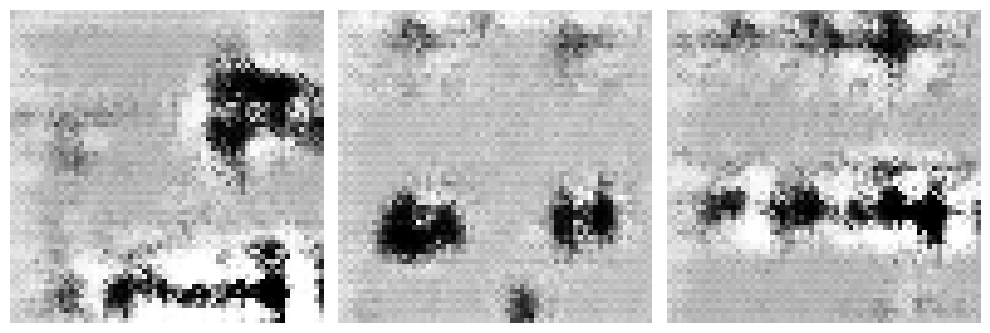

epoch 1 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.664985 ) disc loss( 0.142821 )
1/1 [==============================] - 0s 57ms/step


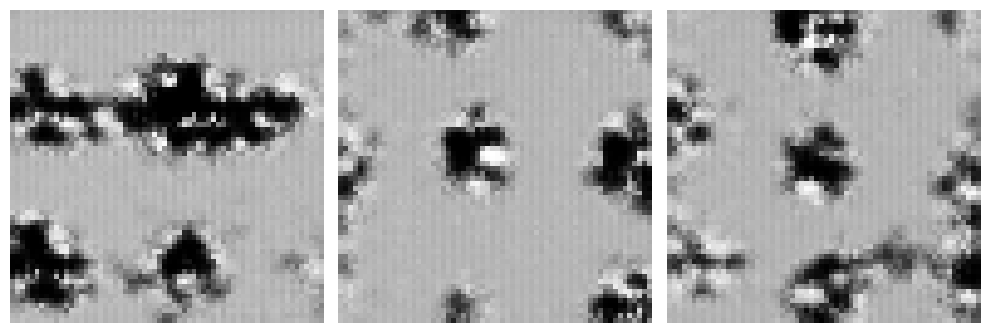

epoch 2 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.653122 ) disc loss( 0.153526 )
1/1 [==============================] - 0s 63ms/step


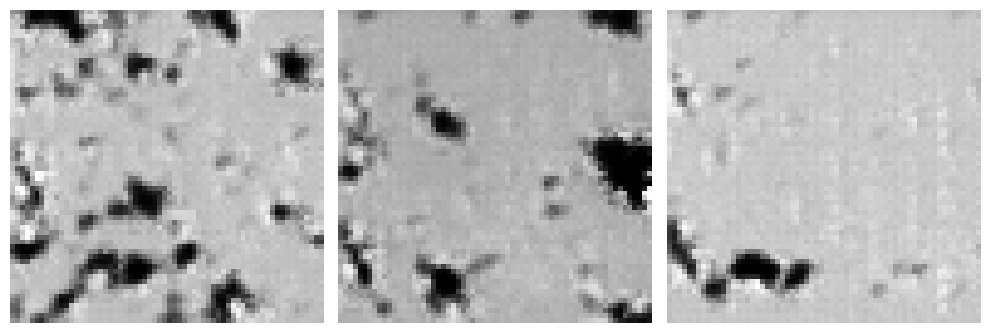

epoch 3 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.639405 ) disc loss( 0.204155 )
1/1 [==============================] - 0s 56ms/step


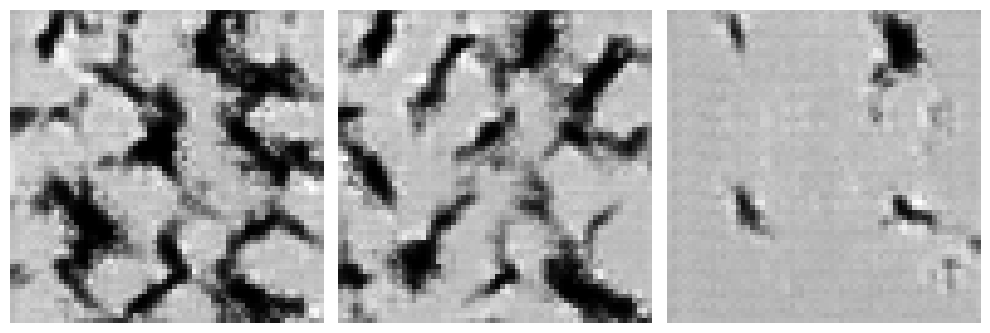

epoch 4 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.621572 ) disc loss( 0.173637 )
1/1 [==============================] - 0s 56ms/step


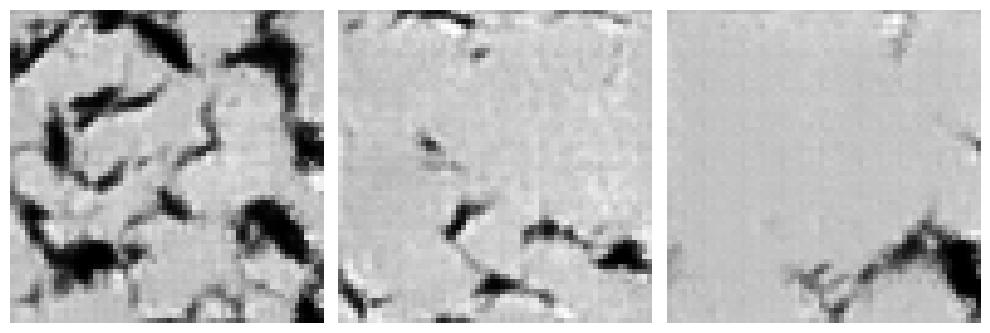

epoch 5 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.60631 ) disc loss( 0.195918 )
1/1 [==============================] - 0s 68ms/step


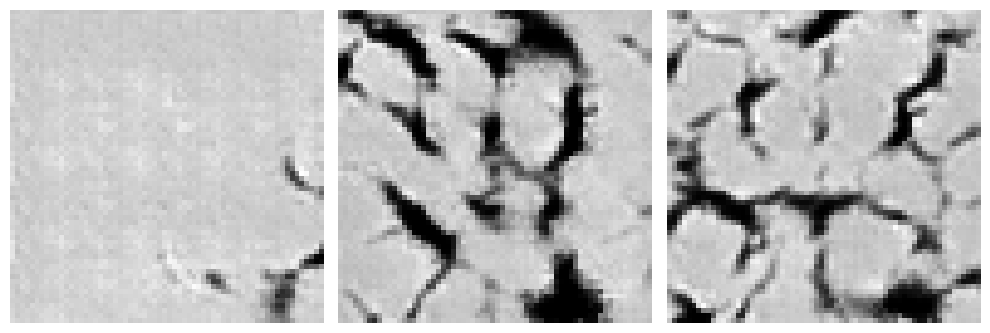

epoch 6 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.534422 ) disc loss( 0.207054 )
1/1 [==============================] - 0s 60ms/step


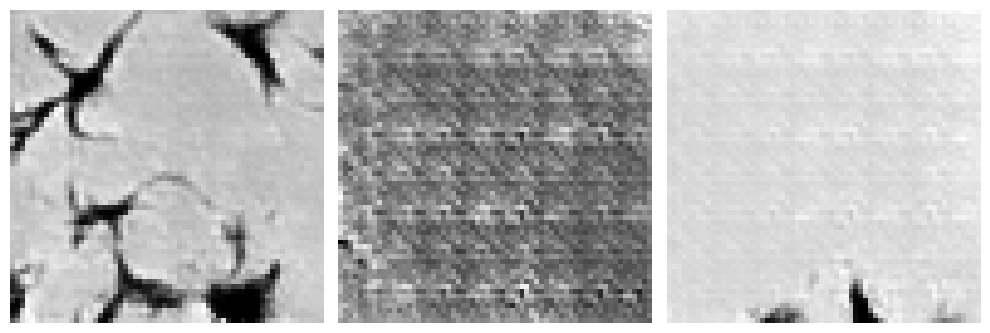

epoch 7 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.475255 ) disc loss( 0.214885 )
1/1 [==============================] - 0s 63ms/step


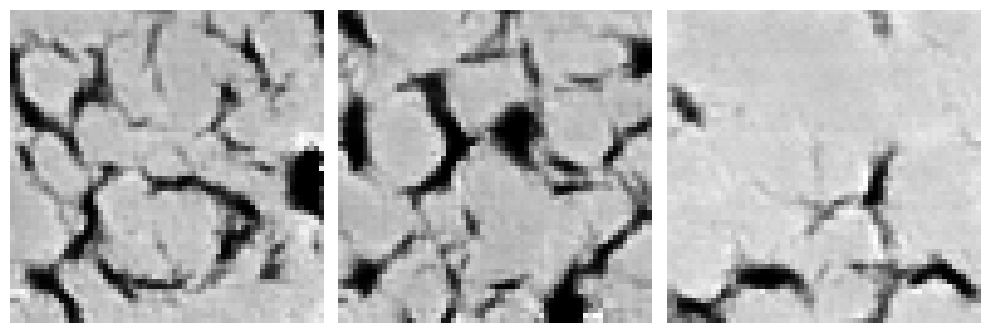

epoch 8 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.335443 ) disc loss( 0.212022 )
1/1 [==============================] - 0s 56ms/step


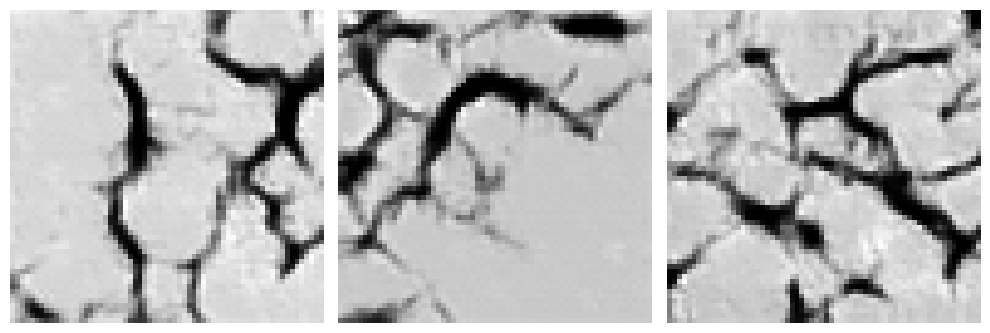

epoch 9 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.273597 ) disc loss( 0.194121 )
1/1 [==============================] - 0s 61ms/step


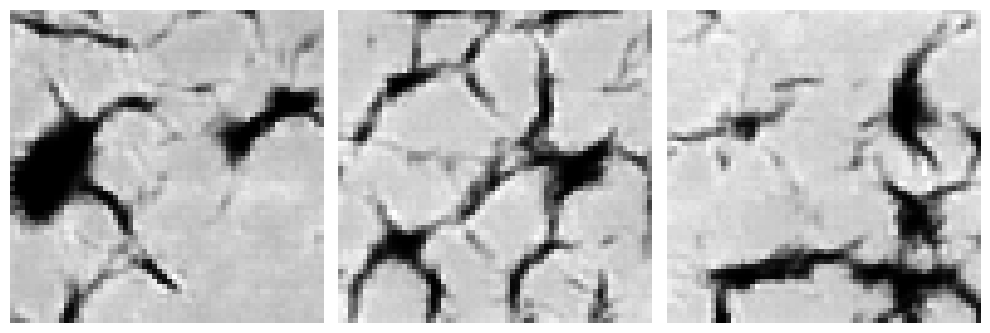

epoch 10 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.434482 ) disc loss( 0.158516 )
1/1 [==============================] - 0s 63ms/step


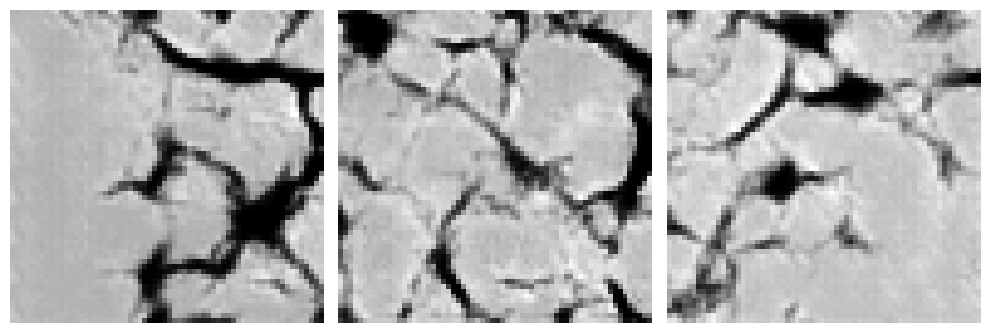

epoch 11 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.44625 ) disc loss( 0.175837 )
1/1 [==============================] - 0s 69ms/step


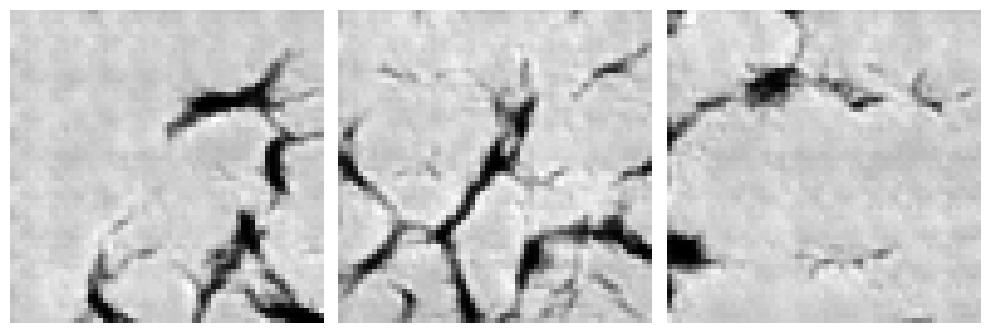

epoch 12 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.646227 ) disc loss( 0.144185 )
1/1 [==============================] - 0s 56ms/step


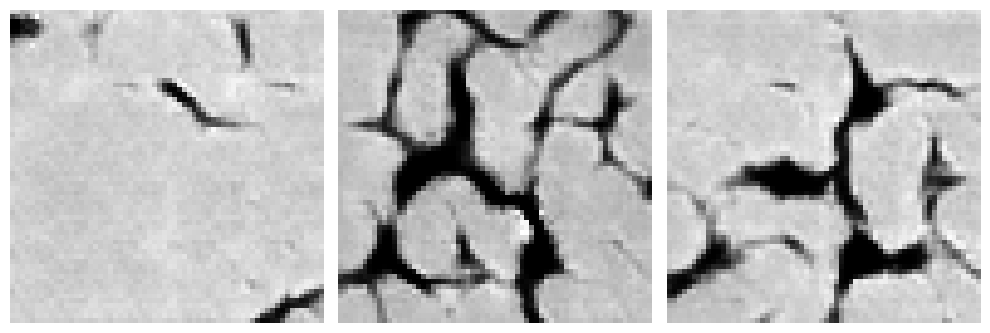

epoch 13 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.521865 ) disc loss( 0.176937 )
1/1 [==============================] - 0s 58ms/step


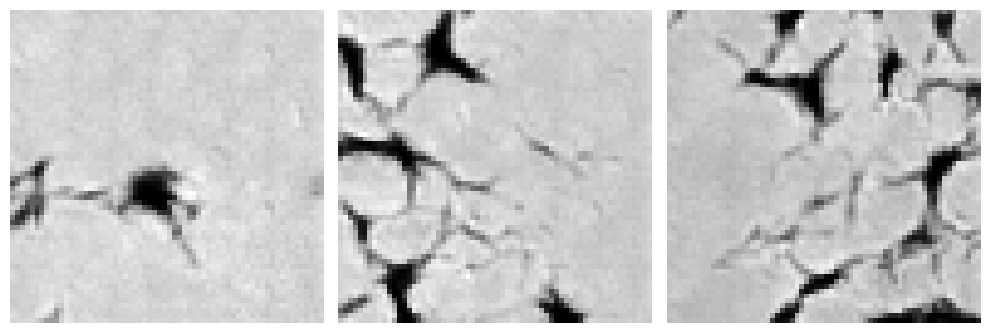

epoch 14 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.466318 ) disc loss( 0.169569 )
1/1 [==============================] - 0s 61ms/step


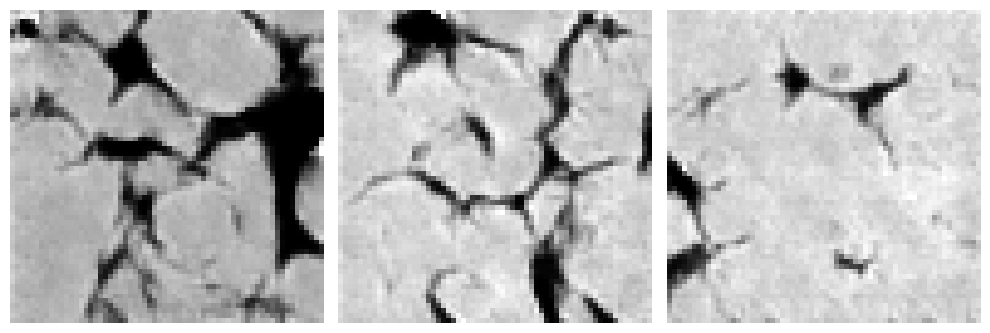

epoch 15 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.561356 ) disc loss( 0.160643 )
1/1 [==============================] - 0s 67ms/step


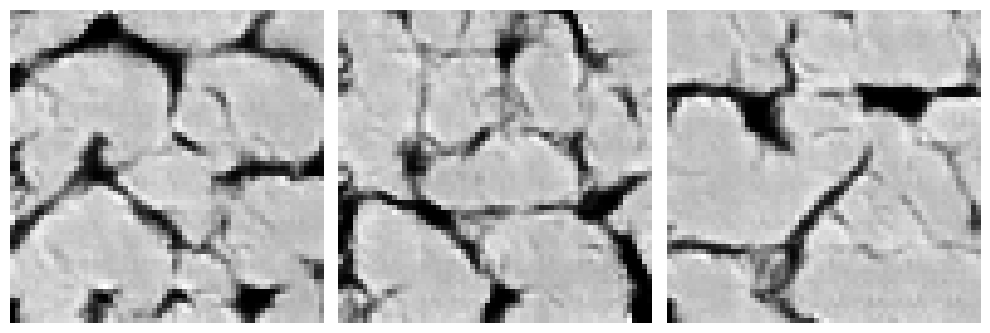

epoch 16 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.548294 ) disc loss( 0.186502 )
1/1 [==============================] - 0s 67ms/step


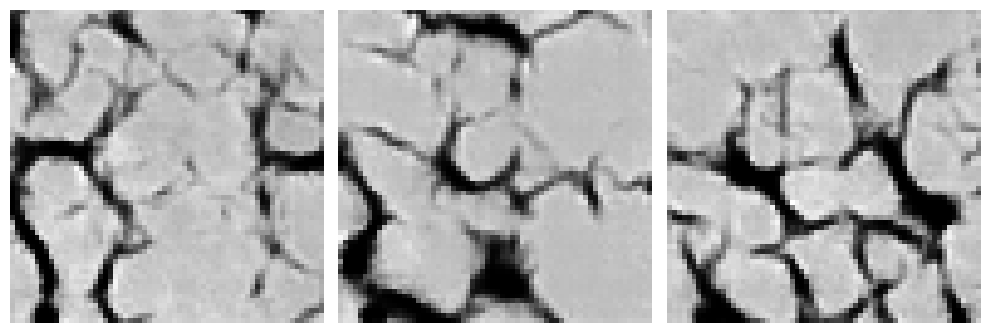

epoch 17 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.438622 ) disc loss( 0.200746 )
1/1 [==============================] - 0s 56ms/step


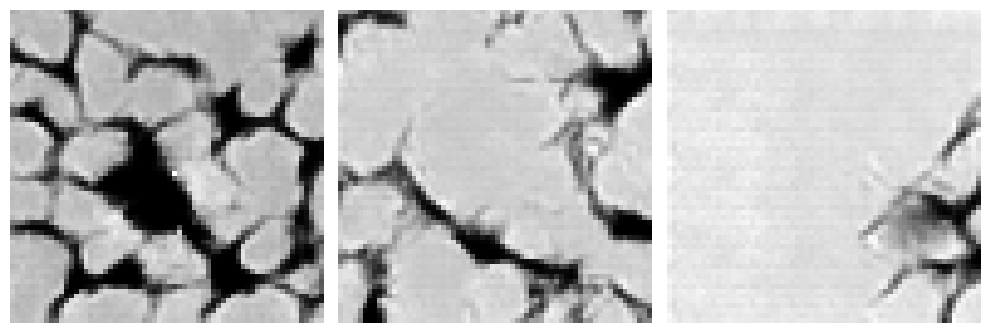

epoch 18 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.357553 ) disc loss( 0.183503 )
1/1 [==============================] - 0s 58ms/step


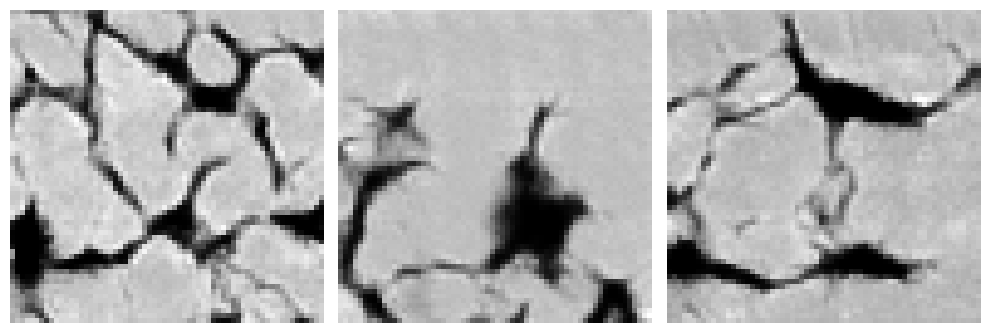

epoch 19 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.344707 ) disc loss( 0.175336 )
1/1 [==============================] - 0s 57ms/step


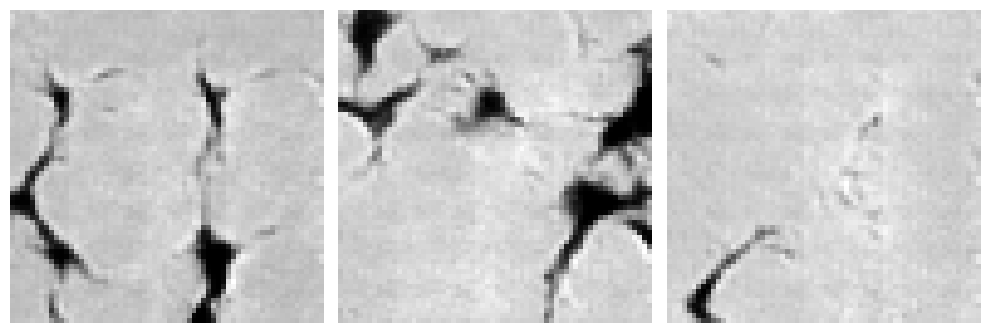

epoch 20 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.233581 ) disc loss( 0.229032 )
1/1 [==============================] - 0s 60ms/step


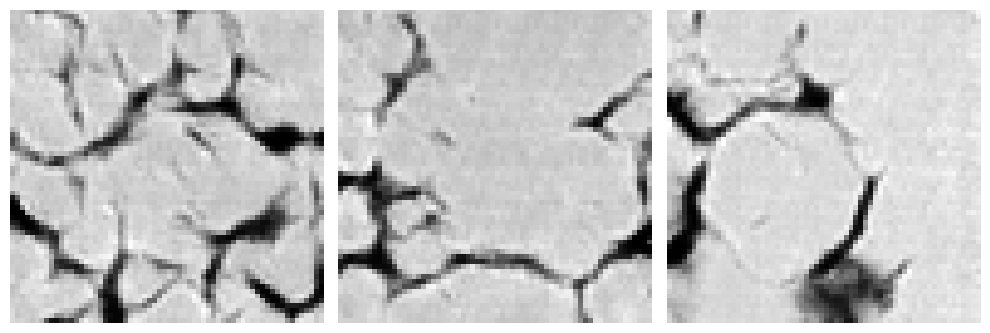

epoch 21 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.248572 ) disc loss( 0.202831 )
1/1 [==============================] - 0s 59ms/step


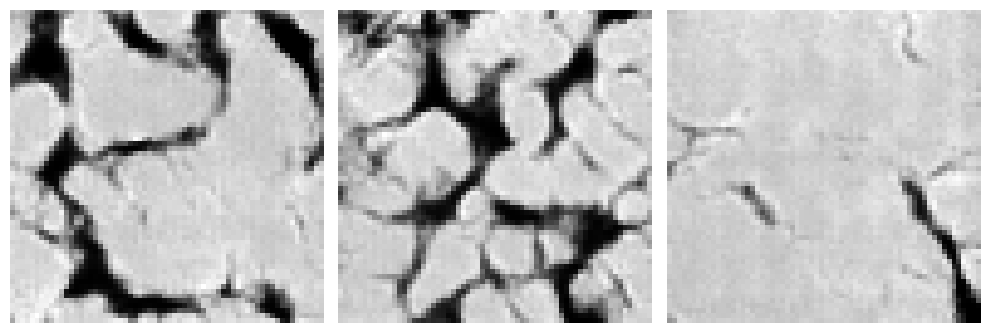

epoch 22 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.390222 ) disc loss( 0.205947 )
1/1 [==============================] - 0s 58ms/step


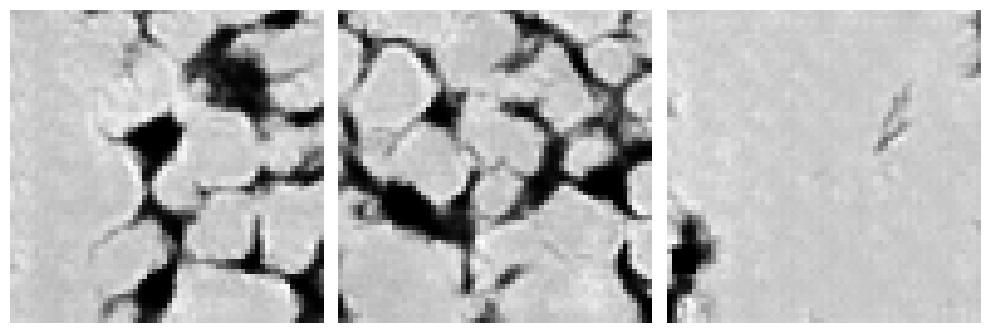

epoch 23 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.324538 ) disc loss( 0.192664 )
1/1 [==============================] - 0s 65ms/step


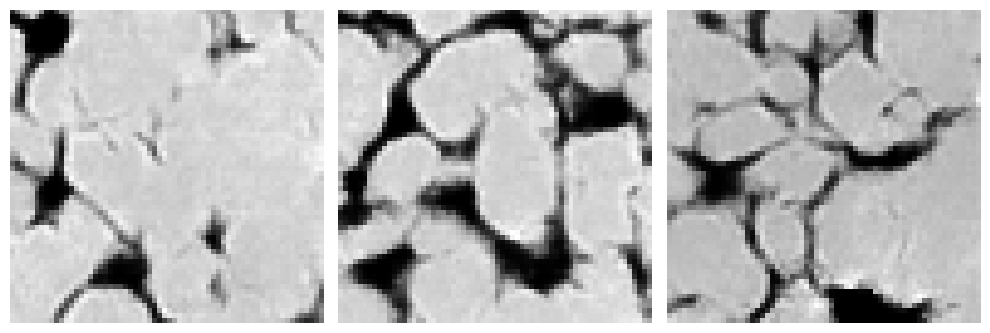

epoch 24 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.282372 ) disc loss( 0.187891 )
1/1 [==============================] - 0s 67ms/step


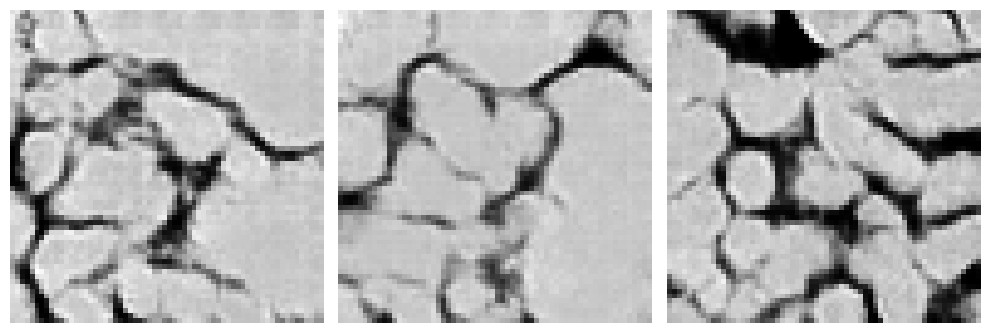

epoch 25 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.254188 ) disc loss( 0.204767 )
1/1 [==============================] - 0s 59ms/step


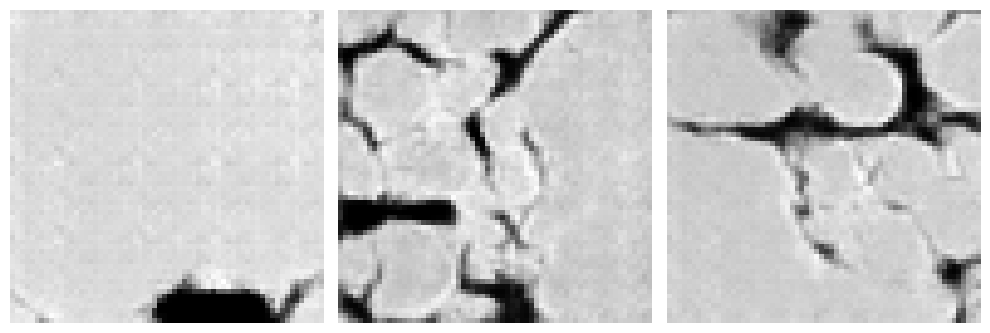

epoch 26 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.243037 ) disc loss( 0.208708 )
1/1 [==============================] - 0s 61ms/step


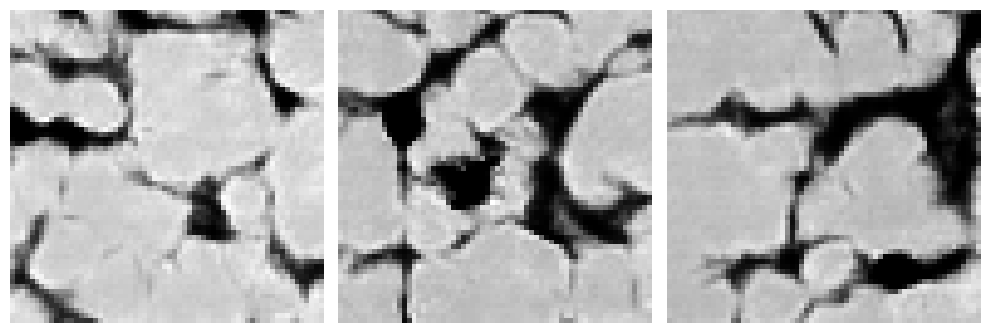

epoch 27 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.238293 ) disc loss( 0.183917 )
1/1 [==============================] - 0s 81ms/step


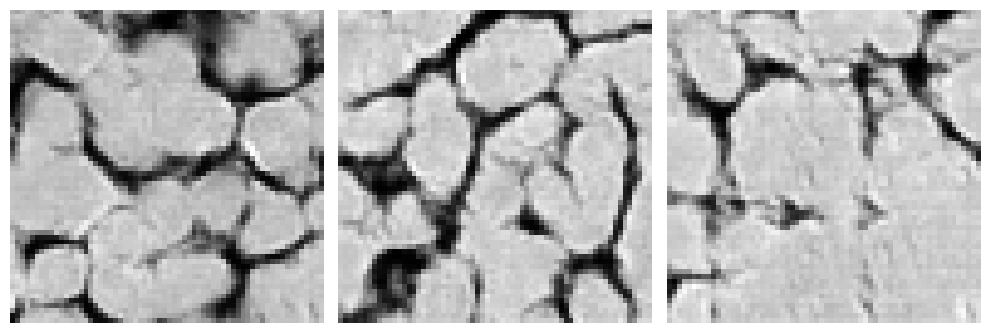

epoch 28 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.384587 ) disc loss( 0.177075 )
1/1 [==============================] - 0s 62ms/step


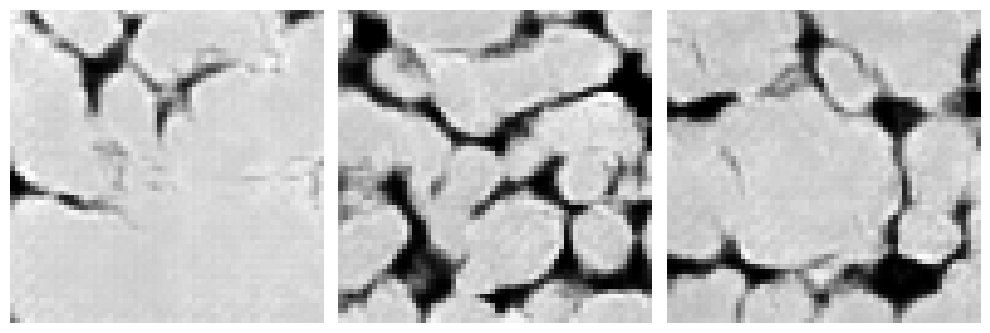

epoch 29 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.374132 ) disc loss( 0.191524 )
1/1 [==============================] - 0s 67ms/step


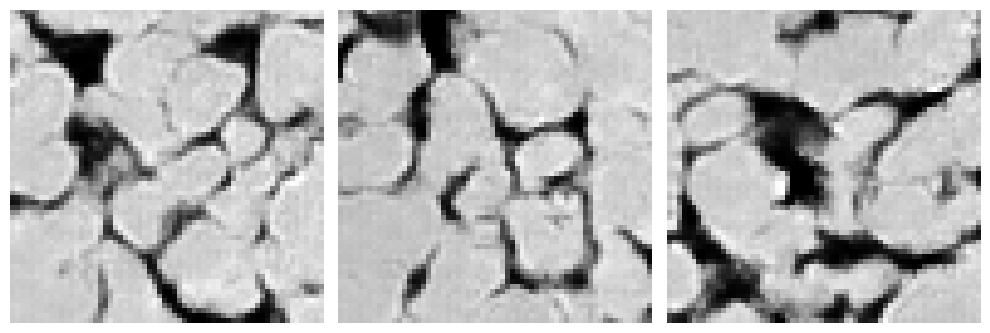

epoch 30 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.061842 ) disc loss( 0.253036 )
1/1 [==============================] - 0s 72ms/step


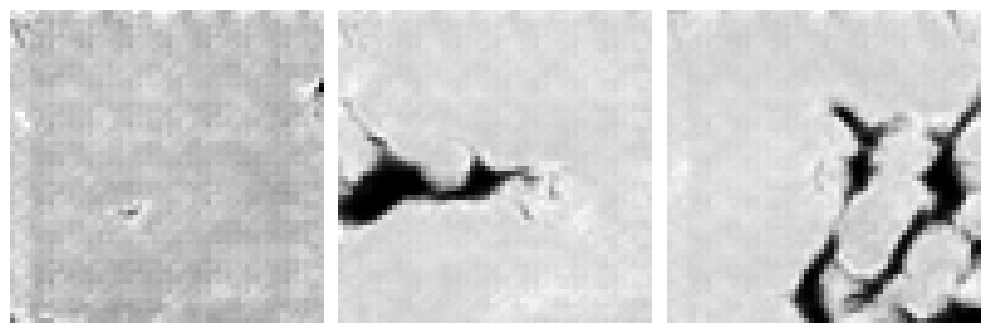

epoch 31 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.074538 ) disc loss( 0.239527 )
1/1 [==============================] - 0s 59ms/step


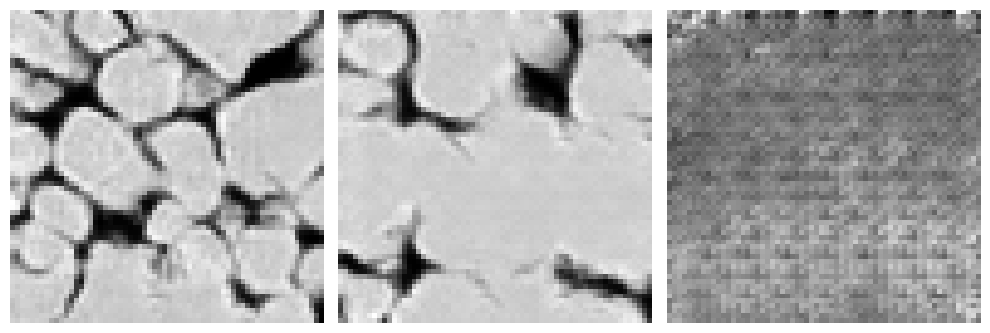

epoch 32 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.130745 ) disc loss( 0.22321 )
1/1 [==============================] - 0s 65ms/step


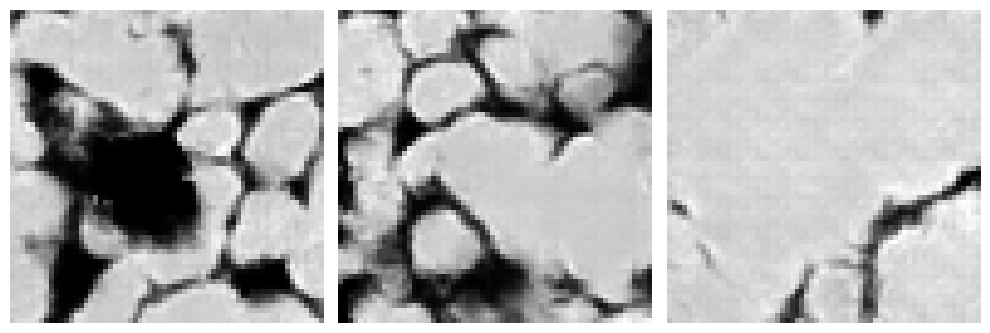

epoch 33 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.111458 ) disc loss( 0.208967 )
1/1 [==============================] - 0s 58ms/step


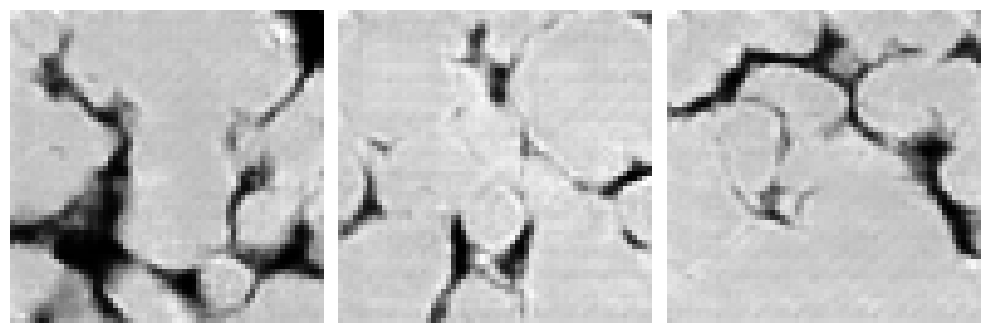

epoch 34 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.136048 ) disc loss( 0.206438 )
1/1 [==============================] - 0s 64ms/step


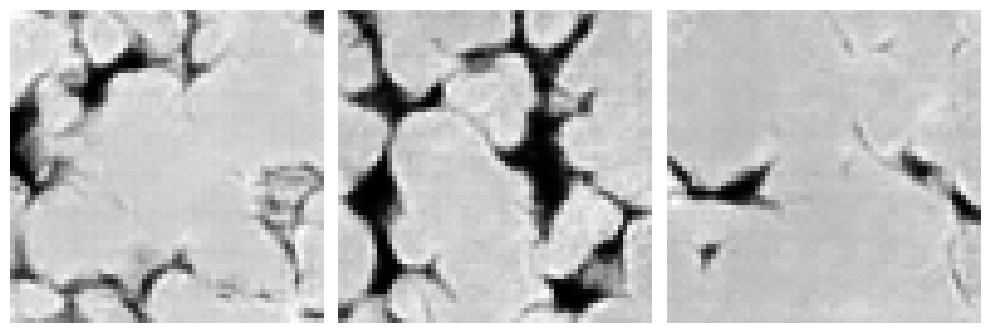

epoch 35 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 2.118389 ) disc loss( 0.227461 )
1/1 [==============================] - 0s 67ms/step


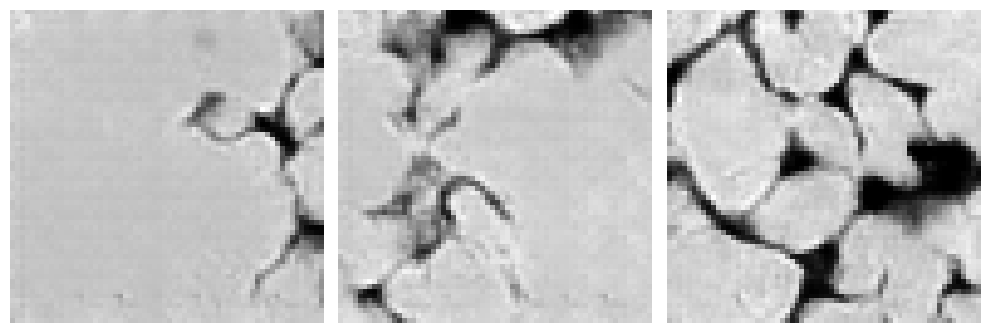

epoch 36 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 1.915658 ) disc loss( 0.268557 )
1/1 [==============================] - 0s 69ms/step


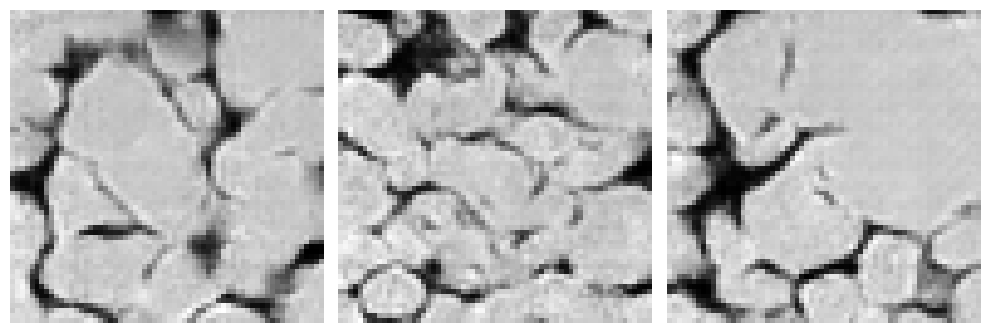

epoch 37 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 1.904214 ) disc loss( 0.258196 )
1/1 [==============================] - 0s 56ms/step


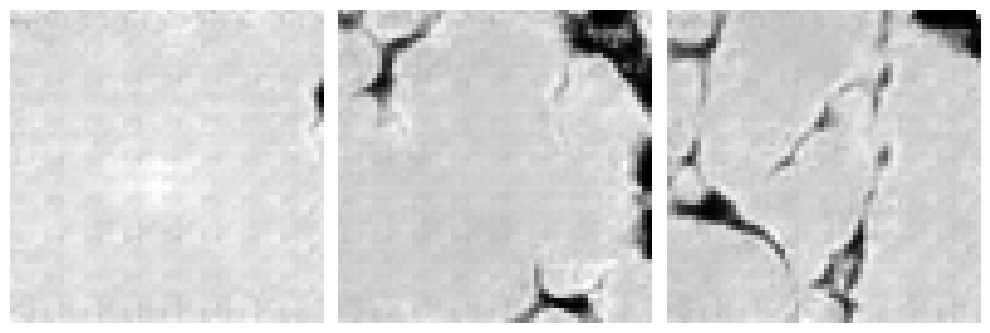

epoch 38 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 1.969536 ) disc loss( 0.235365 )
1/1 [==============================] - 0s 59ms/step


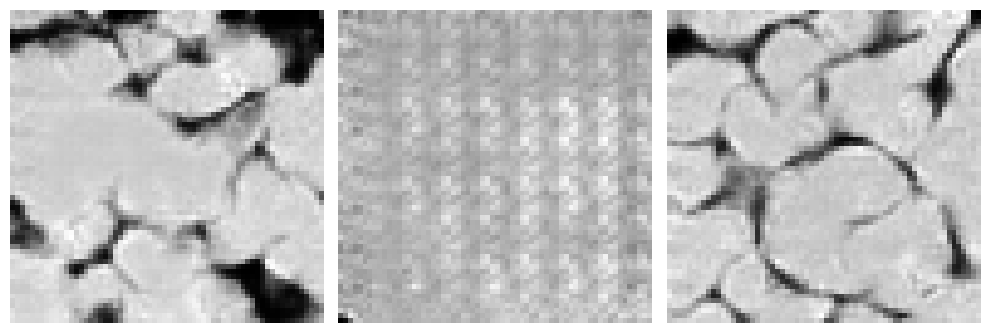

epoch 39 :	0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 gen loss( 1.964275 ) disc loss( 0.236523 )
1/1 [==============================] - 0s 60ms/step


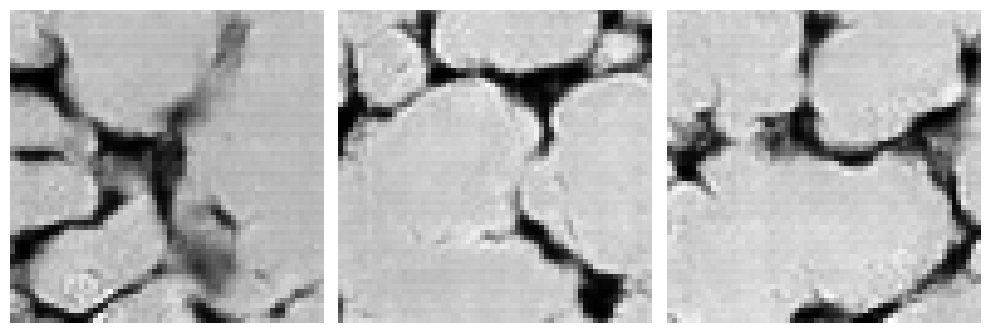

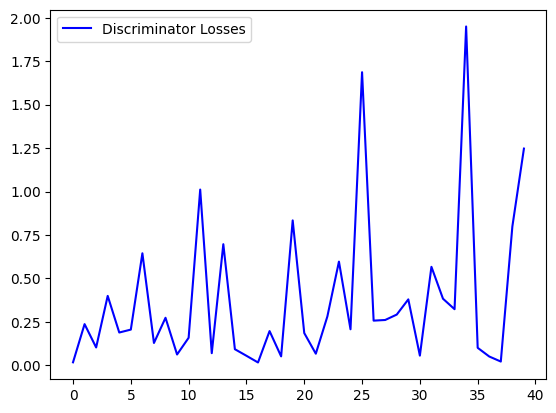

In [10]:
## training
tf.config.run_functions_eagerly(True)
epochs=40
train(epochs)
plt.plot(np.arange(0,epochs,1), disc_losses, "blue",label= "Discriminator Losses")
plt.legend()
plt.show()